<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/W._P._Carey_School_of_Business_logo.png" width=15% align=left> <br><br>
<!-- <img src="https://i.ibb.co/3CJ8vVn/Thumbnail.jpg" width =80%> -->

# Problem Set 3 - Flight Delay Dataset
<!-- <h1 style="text-align: center;color:#8C1D40"> CAR PRICE PREDICTION </h1> -->
<!-- <hr> -->

## Table of Content: <a class="anchor" id="table-of-content"></a>
* [1. Problem Background and Motivation](#problem-background)
* [2. Import Package](#import-package)
* [3. Custom Functions](#custom-functions)
* [4. Connect to Data Source and Data Extraction](#data-extraction)
* [5. Data Exploration, Data Transformation](#data-transformation)
* [6. Machine Learning Model](#ml-model)
* [7. Conclusion](#conclusion)
* [8. Deployment](#deployment)

## 1. Problem Background and Motivation <a class="anchor" id="problem-background"></a>

### Problem Statement
> The airline industry wants to know if flights are likely to be delayed so that they can take the necessary steps to manage the operations at airport and thus improve customers satisfaction. <br>

### Agenda
> Develop a machine learning model that will be used by the operations team to determine whether the flight will be delayed.
>
> **Parameters/Features to monitor which might help in creating machine learning model :**
>- Carrier
>- Scheduled departure time
>- Destination
>- Distance
>- Origin
>- Weather

### Goal
> 1. Efficiently predict if the flight will be delayed or not.
> 2. Reduce the number of false positives, which happen when a flight isn't delayed but the model predicts it will be. Because we will be using this model to notify customers whether there is a flight delay or not, false positive cases will result in a decrease in customer experience because customers may miss their flight.
> 3. Since we need to reduce False Positives, we will **monitor Precision and Accuracy** while keeping the False negatives at a lower level
> 4. High false negative cases will lead to customers spending a lot of time at airport and will eventually lead to decrease in customers experience 


* [Go to Top](#table-of-content)

## 2. Import Package <a class="anchor" id="import-package"></a>
<br>

### Libraries<br>

>**Numpy, Pandas and Math:**<br>
We use it to import the data files which has multi-dimensional arrays and matrices and for data manipulations  <br>

>**Matplotlib, Seaborn and Plotly:**<br>
These libraries are used for data visualization

>**SKLearn:**<br>
Sklearn provides multiple machine learning and statistical models to which can best describe the pattern in the data. It also provides metrics toevaluate the performance of the model    <br>

>**Statsmodels:**<br>
Statsmodels is used for statistical tests on statistical data explorations <br>


* [Go to Top](#table-of-content)

In [119]:
# data manipulation libraries
import pandas as pd
pd.set_option('display.max_columns',None)
pd.options.display.float_format = '{:.4f}'.format 
import numpy as np
import math

# visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# statistics library
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# model deployment
import pickle
import streamlit as st


## 3. Custom functions and Global Variables <a class="anchor" id="custom-functions"></a>
User defined functions which will be used multiple times in the below notebook.

Glossary of User defined functions:
1. **z_null_value_check** - function to check null value count and null value % in the dataframe.
2. **highlight_cells** - function to highlight cells in the dataframe. 
3. **z_describe_numerics** - function to get summary of numerical colums
4. **z_target_by_category** - function to get mean statistics between of categorical colums and target variable
5. **train_test_metrics_classification** - function to get the evaluation metrics for Classification model

* [Go to Top](#table-of-content)

In [120]:
# function to check null value count and null value % in the dataframe. 
# The function generate a chart to show missing values in the data.

def z_null_value_check(df):
    '''
    Function to track null values in the dataframe
    '''
    null_count = df.isnull().sum()
    null_percentage = 100* null_count/df.count()
    
    null_df = pd.DataFrame(dict(
        null_count = null_count,
        null_percentage = null_percentage.round(2)
    ))
    display(null_df)
#     display(df.isnull().sum())
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [121]:
# function to highlight cells in the dataframe. 
def highlight_cells(val, color_if_true,threshold):
    color = color_if_true if abs(val) > threshold else ''
    return 'background-color: {}'.format(color)

# function to get summary of numerical colums
def z_describe_numerics(df,feature_list=[]):
    '''
    The function provides following details related to numerical columns:
    1. Count of records
    2. Mean
    3. Median
    4. Standard Deviation
    5. Minimum Value
    6. Maximum Value
    7. Skewness Coefficient - cell values are highlighted if skewness increases the threshold value
    8. Number of outliers (Outliers flagged based inter quartile range)
    9. Percentage of outliers
    10. Interquartile lower and upper limit - can be used to remove outliers
    
    Note: This function assumes the input dataframe (X) has numerical columns.
    '''
    numerics = ['int16','int32','int64','float16','float32','float64']
    outlier_threshold = .05
    skewness_threshold = 3
    
    feature_list = df.select_dtypes(include=numerics).columns if len(feature_list) == 0 else feature_list
    
    quartile_1 = df[feature_list].quantile(0.25)
    quartile_3 = df[feature_list].quantile(0.75)
    IQR = quartile_3 - quartile_1
    
    outlier_lower_threshold= quartile_1 - 1.5*IQR
    outlier_upper_threshold= quartile_3 + 1.5*IQR
    
    outlier = ((df[feature_list] < outlier_lower_threshold) | (df[feature_list] > outlier_upper_threshold))
    
    temp_df = pd.DataFrame(dict(
        count = df[feature_list].count(),
        mean = df[feature_list].mean().round(2),
        median = df[feature_list].median().round(2),
        std_dev = df[feature_list].std().round(2),
        min_val = df[feature_list].min(),
        max_val = df[feature_list].max(),
        skewness= df[feature_list].skew().round(2),
        
        outlier_count = outlier.sum(),
        outlier_percentage = (100*outlier.sum()/df[feature_list].count()).round(2),
        outlier_lower_limit = outlier_lower_threshold,
        outlier_upper_limit = outlier_upper_threshold,
        
        # flag the column if outlier percentage is more than 5% or skewness is more than 3
        outlier_issue = np.where((outlier.sum()/df[feature_list].count() > outlier_threshold)
                                 | (df[feature_list].skew() > skewness_threshold) , True, False)
    ))
    
    temp_df= temp_df.style.format(precision=2).applymap(highlight_cells,color_if_true='#ff716b',threshold=skewness_threshold,subset=['skewness'])
    
    return temp_df

# function to get mean statistics between of categorical colums and target variable
def z_target_by_category(X):
    '''
    This function assumes the input dataframe (X) has a numerically defined target
    variable in the first column and that all remaining features are categorical
    '''
    global_mean = X.iloc[:,0].mean()
    target = X.columns[0]
    for col in X.columns[1:]:
        df_group = X.groupby(by=col)[target].agg(['mean']).round(2)
        df_group['diff'] = (df_group['mean'] - global_mean).round(2)
        display(df_group.sort_values(by='mean'))

In [122]:
# Required inputs are the model name and the two test data objects (X,y)
def train_test_metrics_classification(model,X_test,y_test,threshold_start=0,threshold_end=1.1,threshold_interval=0.1):
    '''
    The function generates a dataframe of evaluation metrics for measuring classification model performance at different probability thresholds. 
    '''
    
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    FP_rate=[]
    FN_rate=[]
    
    # Create list of probability threshold values to loop over
#     threshold = np.arange(0,1.1,0.1).tolist()
    threshold = np.arange(threshold_start,threshold_end,threshold_interval).tolist()

    # Start loop to calculate performance measures for each threshold
    for i in threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)
        
        # performance metrics 
        model_confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred_class)
        recall_score = metrics.recall_score(y_test, y_test_pred_class)
        precision_score = metrics.precision_score(y_test, y_test_pred_class)
        f1_score = metrics.f1_score(y_test, y_test_pred_class)
        accuracy = metrics.accuracy_score(y_test, y_test_pred_class)
        fp_rate = model_confusion_matrix[0][1]/(model_confusion_matrix[0][0]+model_confusion_matrix[0][1])
        fn_rate = model_confusion_matrix[1][0]/(model_confusion_matrix[1][0]+model_confusion_matrix[1][1])

        # Append lists with metric values
        TP.append(model_confusion_matrix[1,1])
        TN.append(model_confusion_matrix[0,0])
        FP.append(model_confusion_matrix[0,1])
        FN.append(model_confusion_matrix[1,0])
        recall.append(recall_score.round(3))
        precision.append(precision_score.round(3))
        F1.append(f1_score.round(3))
        Accuracy.append(accuracy.round(3))
        FP_rate.append(fp_rate.round(3))
        FN_rate.append(fn_rate.round(3))

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "Precision":precision,
                           "Recall":recall,
                           "F1":F1,
                           "Accuracy": Accuracy,
                           "FP_rate": FP_rate,
                           "FN_rate": FN_rate
                          })
    
    display(result)
    
    # add script to plot accuracy, precision, recall for each threshold
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result['threshold'], y=result['Precision'],
                        mode='lines+markers',
                        name='Precision'))
    fig.add_trace(go.Scatter(x=result['threshold'], y=result['Recall'],
                        mode='lines+markers',
                        name='Recall'))
    fig.add_trace(go.Scatter(x=result['threshold'], y=result['F1'],
                        mode='lines+markers', name='F1'))
    fig.add_trace(go.Scatter(x=result['threshold'], y=result['Accuracy'],
                        mode='lines+markers', name='Accuracy'))
    
    fig.update_layout(yaxis_range=[0,1])
    fig.show()

    # Let's look at our dataframe
    return result

In [123]:
# Required inputs are the model name and the two test data objects (X,y)
def knn_performance_by_k(X_train,X_test,y_train,y_test,k_start=1,k_end=20,k_interval=2):
    '''
    The function generates a dataframe of evaluation metrics for kNN model, for different values of K. 
    '''
    
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    FP_rate=[]
    FN_rate=[]
    
    # Create list of probability threshold values to loop over
#     threshold = np.arange(0,1.1,0.1).tolist()
    k_range = range(k_start,k_end,k_interval)

    # Start loop to calculate performance measures for each threshold
    for k in k_range:
        
        # create KNN model
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train,y_train.values.ravel())

        # predict output for test data
        y_test_pred_class = model.predict(X_test)
        
        # performance metrics 
        model_confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred_class)
        recall_score = metrics.recall_score(y_test, y_test_pred_class)
        precision_score = metrics.precision_score(y_test, y_test_pred_class)
        f1_score = metrics.f1_score(y_test, y_test_pred_class)
        accuracy = metrics.accuracy_score(y_test, y_test_pred_class)
        fp_rate = model_confusion_matrix[0][1]/(model_confusion_matrix[0][0]+model_confusion_matrix[0][1])
        fn_rate = model_confusion_matrix[1][0]/(model_confusion_matrix[1][0]+model_confusion_matrix[1][1])

        # Append lists with metric values
        TP.append(model_confusion_matrix[1,1])
        TN.append(model_confusion_matrix[0,0])
        FP.append(model_confusion_matrix[0,1])
        FN.append(model_confusion_matrix[1,0])
        recall.append(recall_score.round(3))
        precision.append(precision_score.round(3))
        F1.append(f1_score.round(3))
        Accuracy.append(accuracy.round(3))
        FP_rate.append(fp_rate.round(3))
        FN_rate.append(fn_rate.round(3))

    # Create dataframe
    result = pd.DataFrame({"k":k_range,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "Precision":precision,
                           "Recall":recall,
                           "F1":F1,
                           "Accuracy": Accuracy,
                           "FP_rate": FP_rate,
                           "FN_rate": FN_rate
                          })
    
    display(result)
    
    # add script to plot accuracy, precision, recall for each threshold
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result['k'], y=result['Precision'],
                        mode='lines+markers',
                        name='Precision'))
    fig.add_trace(go.Scatter(x=result['k'], y=result['Recall'],
                        mode='lines+markers',
                        name='Recall'))
    fig.add_trace(go.Scatter(x=result['k'], y=result['F1'],
                        mode='lines+markers', name='F1'))
    fig.add_trace(go.Scatter(x=result['k'], y=result['Accuracy'],
                        mode='lines+markers', name='Accuracy'))
    
    fig.update_layout(yaxis_range=[0,1])
    fig.show()

    # Let's look at our dataframe
    return result

## Declare Global Variables

In [124]:
# common variables used in the notebook
numerics = ['int16','int32','int64','float16','float32','float64']
categorical = ['object']

## 4. Connect to Data Source and Data Extraction <a class="anchor" id="data-extraction"></a>
1. The below cells loads the data from flat file and creates a source dataframe. 
2. Source data frame is copied so that we dont have to rextract the data from source.  
3. We will be using the copied dataframe to analyze the data, feature selection and for running machine learning model.

| Source       	|                       	        |
|--------------	|-------------------------------	|
| File Name:   	| FlightDelays_Clean.csv                 	        |
| File Location:| CIS 508\Assignment\Assignment 3   |

**Note:**
Check the row and column count of the table prior to loading the data into python dataframe.  

* [Go to Top](#table-of-content)

### 4.1 Check the row and column count and load the source data

In [125]:
file_name='FlightDelays_Clean.csv'
rows = sum(1 for line in open(file_name)) - 1 # -1 to remove header row count
columns = pd.read_csv(file_name, nrows=10).shape[1]

print('Number of rows:', rows)
print('Number of columns:', columns)

Number of rows: 2201
Number of columns: 23


> Number of rows and columns in the source data are not very high. We can load the data in one go.
>
> Note: if the data size is more, load the data in batches

In [126]:
df_raw = pd.read_csv('FlightDelays_Clean.csv')
df = df_raw.copy()
df.tail()

,status_delayed,sch_dep_time,carrier_delta,carrier_us,carrier_envoy,carrier_continental,carrier_discovery,carrier_other,dest_jfk,dest_ewr,dest_lga,distance,origin_dca,origin_iad,origin_bwi,bad_weather,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2196,0,21.3300,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,1,0,0,0
2197,0,21.3300,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,0,1,0,0
2198,0,21.3300,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,0,0,1,0
2199,0,21.3300,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,0,0,0,1
2200,0,21.3300,0,0,0,0,1,0,0,0,1,229,0,1,0,0,1,0,0,0,0,0,0


#### Inital Observation:
> **Total Records**: 2200 records <br>
> **Target Variable**: status_delayed (1 if flight is delayed, 0 if flight is not delayed) <br>
>
> Data Definition

| Column Name       	|     Column Definition  |
|--------------	|-------------------------------	|
| status_delayed   	| Determines if the flight is delayed or not. 1 if flight is delayed|
| sch_dep_time | Estiamted time at which flight will depart  |
| carrier | Ariline operator for the flight |
| dest | Destination of the flight |
| origin | Origin of the flight |
| distance | Distance between Origin and destination |
| bad_weather | Weather at the time of departure. 1 indicates cloudy-rainy wheather; 0 indicates clear sky |
| weekday name | Day on which the flight is scheduled. This column includes dayname i.e. Sunady, Monday etc. |

## 5. Data Exploration, Data Transformation <a class="anchor" id="data-transformation"></a>

1. [Initial Cleanup - dupes, missing values](#initial-cleanup)
2. [Outlier Detection & Treatment](#outlier-detection)
3. [Feature Creation](#feature-creation)
4. [Feature Selection](#feature-selection)
5. [Feature Transformations](#feature-transformations)
6. [Data Partitioning](#data-split)
7. [Data Scaling](#data-normalization)

* [Go to Top](#table-of-content)

### 5.1 Initial Cleanup <a class="anchor" id="initial-cleanup"></a>
Remove Duplicates and missing values

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

#### 5.1.1 Review column names
Review column name and rename column names - change the column names to lower case and remove space between multiple words, so that it is easier to use while coding 

In [127]:
# print(df.columns)

# no need to change the column names as all the column names are as expected

#### 5.1.2 Review data type of columns
Python selects the data type for the columns while loading the data. Update the data type if there is any issue

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   status_delayed       2201 non-null   int64  
 1   sch_dep_time         2201 non-null   float64
 2   carrier_delta        2201 non-null   int64  
 3   carrier_us           2201 non-null   int64  
 4   carrier_envoy        2201 non-null   int64  
 5   carrier_continental  2201 non-null   int64  
 6   carrier_discovery    2201 non-null   int64  
 7   carrier_other        2201 non-null   int64  
 8   dest_jfk             2201 non-null   int64  
 9   dest_ewr             2201 non-null   int64  
 10  dest_lga             2201 non-null   int64  
 11  distance             2201 non-null   int64  
 12  origin_dca           2201 non-null   int64  
 13  origin_iad           2201 non-null   int64  
 14  origin_bwi           2201 non-null   int64  
 15  bad_weather          2201 non-null   i

#### 5.1.3 Drop duplicate rows

In [129]:
# remove duplicates
print('number of records',len(df))

df = df.drop_duplicates()

print('number of records after deleting duplicates',len(df))

number of records 2201
number of records after deleting duplicates 882


#### 5.1.4 Check for Null values

In [130]:
# z_null_value_check(df)

> No null values in the data

#### Initial Cleanup Summary
>1. Deleted 1319 duplicate rows from the data. 
>2. No null values in the data
>
>**Total Number of rows after cleanup = 882**

### 5.2 Outlier Detection and Removal <a class="anchor" id="outlier-detection"></a>

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

#### 5.2.1 Outlier Detection

In [131]:
# summary of numerical variables
# z_describe_numerics(df)

<Figure size 640x480 with 0 Axes>

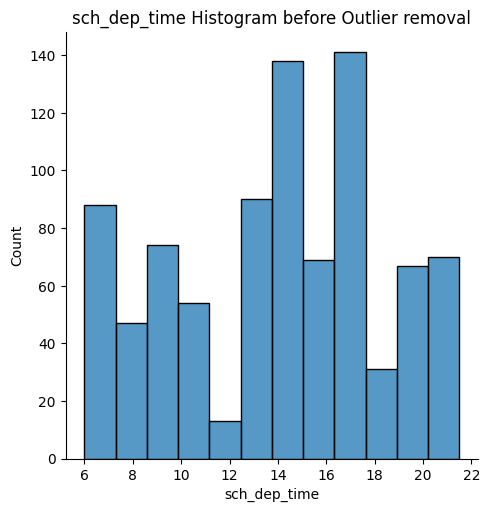

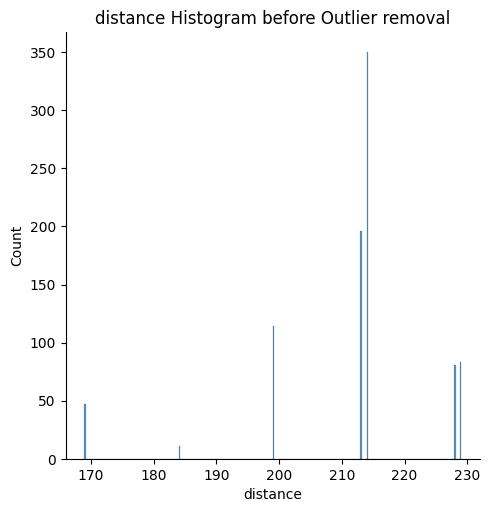

In [132]:
# # histogram plots for columns which might have outliers
graph_columns=['sch_dep_time','distance']

for i, col in enumerate(graph_columns):
    plt.figure(i)
    sns.displot(df[col])
    plt.title(col + ' Histogram before Outlier removal')

**Outlier Detection Summary**
> 1. No outliers in the dataset


#### 5.2.2 Outlier Removal

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

In [133]:
#

>**Outlier Treatment Summary** <br>
> No Outliers
>
>**Total Number of rows after cleanup = 882**


### 5.3 Feature Creation <a class="anchor" id="feature-creation"></a>

1. Create new features based on current data
2. Reduce the number of unique values (if possible)

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

In [134]:
#

>**Feature Creation Summary** <br>
> All features are already cleaned from source  

### 5.4 Feature selection <a class="anchor" id="feature-selection"></a>
Select the features on which Price is dependent. Feature selection is divided into:
1. [Numerical features](#numerical-feature-selection)
2. [Categorical Features](#categorical-feature-selection)

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

#### 5.4.1 Numerical Feature Selection <a class="anchor" id="numerical-feature-selection"></a>

In [135]:
# target_variable = 'status_delayed'

# a = df.select_dtypes(include =numerics).corr()[[target_variable]].drop(target_variable).round(2)

# fig = px.bar(x=a.status_delayed[:],y=a.index[:],data_frame=a, orientation='h',color=a.status_delayed[:],
#              color_continuous_scale=px.colors.sequential.Viridis,
#              title='Correlation between Numerical variables and Flight Delay (target variable)'
#             )
# fig.show()

# sns.scatterplot(data=df,x='sch_dep_time',y='status_delayed')

>**Note:** <br>
>Selected Numerical features:
> 1. distance can be derived from Origin to destination. thus we might drop distance column. Check!!

#### 5.4.2 Categorical Feature Selection <a class="anchor" id="categorical-feature-selection"></a>

In [136]:
# df.select_dtypes(include=categorical).nunique()

>**Assessment of Categorical Variables:**<br>
<br>
>Data set does not contain any categorical variables

**Feature Selection Summary**

Following features have been selected to predict if the flight is delayed or not.

> **Numerical Features:**
> 1. sch_dep_time
>
> **Categorical variables:** <br>
> It looks like follwing categorical columns are already converted to following numerical variable
> 1. carrier
> 2. origin
> 3. destination
> 4. weather 

### 5.5 Feature Transformations <a class="anchor" id="feature-transformations"></a>
>To Do:<br>
> 1. Encode categorical variables

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

#### 5.5.1 Encode categorical variables using get_dummies

In [137]:
# # Flag categorical variables and convert to dummies
# cat_vars = df.select_dtypes(include=['object']).columns

# # Loop over categorical vars and encode each one
# for var in cat_vars:
#     df[var] = df[var].astype("category")

# df = pd.get_dummies(df,columns=cat_vars, prefix_sep='_')

In [138]:
# df.columns

In [139]:
# manually dropping the columns so that we have more control over model (if required)
df = df.drop('distance',axis=1)

### 5.6 Train Test Split <a class="anchor" id="data-split"></a>

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

In [140]:
X = df.drop(['status_delayed'],axis=1)

y = df['status_delayed']

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=2)

### 5.7 Data Normalization <a class="anchor" id="data-normalization"></a>

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

In [141]:
# df.head()
# sns.displot(X_train['sch_dep_time'])

In [142]:
scaler = StandardScaler()
scaler.fit(X_train[['sch_dep_time']])
X_train['sch_dep_time'] = scaler.transform(X_train[['sch_dep_time']])
X_test['sch_dep_time'] = scaler.transform(X_test[['sch_dep_time']])

In [143]:
# sns.displot(X_train['sch_dep_time'])

**Data Exploration/Transformation Summary**

>1. removed duplicate rows
>2. Train test split of 70:30 has been taken
>3. Normalized the numerical variables using Standard scaler
>**Total Number of rows after cleanup = 882**

* [Go to Data Exploration/Transformation](#data-transformation)
* [Go to Top](#table-of-content)

## 6. Machine Learning <a class="anchor" id="ml-model"></a>

- [X] [1. Naive Baseline](#naive-baseline)
- [X] [2. kNN](#first-model)
- [X] [3. Logistic Model](#second-model)
- [X] [4. Final Model Selection](#final-model)
- [X] [5. Performance Evaluation](#performance-evaluation)


* [Go to Top](#table-of-content)

### 6.1. Naive Baseline <a class="anchor" id="naive-baseline"></a>
Calculating naive baseline for our dataset

#### Naive Baseline of Training Data

In [144]:
print('Count of flight on time(0) and delayed(1):')
print(y_train.value_counts())
print('\n')
print('%.2f percent of the flights are delayed' %(y_train.mean()*100))
print('%.2f percent of the flights are not delayed' %(100-(y_train.mean()*100)))

Count of task not completed and task completed:
0    401
1    216
Name: status_delayed, dtype: int64


35.01 percent of the flights are delayed
64.99 percent of the flights are not delayed


> **Our naive baseline is 65% i.e. if we predict that the flight will not be delayed for all our train records, we will be 65% accurate in predicting it**


#### Naive Baseline of Testing Data

In [145]:
print('Count of flight on time(0) and delayed(1):')
print(y_test.value_counts())
print('\n')
print('%.2f percent of the flights are delayed' %(y_test.mean()*100))
print('%.2f percent of the flights are not delayed' %(100-(y_test.mean()*100)))

Count of task not completed and task completed:
0    168
1     97
Name: status_delayed, dtype: int64


36.60 percent of the flights are delayed
63.40 percent of the flights are not delayed


> **Our naive baseline of testing data is 64% i.e. if we predict that the flight will not be delayed for all our train records, we will be 64% accurate in predicting it**

### 6.2. Model 1 - KNN <a class="anchor" id="first-model"></a>

Predict the target variable using K nearest neighbour method

> 1. Create mulitple kNN models using multiple values of k
> 2. Choose the best value of k based on accuracy and Precision

* [Go to Machine Learning](#ml-model)
* [Go to Top](#table-of-content)

In [146]:
knn_model_metrics= knn_performance_by_k(X_train,X_test,y_train,y_test,k_end=22)

,k,TP,TN,FP,FN,Precision,Recall,F1,Accuracy,FP_rate,FN_rate
0,1,15,94,74,82,0.1690,0.1550,0.1610,0.4110,0.4400,0.8450
1,3,18,123,45,79,0.2860,0.1860,0.2250,0.5320,0.2680,0.8140
2,5,17,137,31,80,0.3540,0.1750,0.2340,0.5810,0.1850,0.8250
3,7,11,143,25,86,0.3060,0.1130,0.1650,0.5810,0.1490,0.8870
4,9,12,146,22,85,0.3530,0.1240,0.1830,0.5960,0.1310,0.8760
5,11,9,148,20,88,0.3100,0.0930,0.1430,0.5920,0.1190,0.9070
6,13,10,149,19,87,0.3450,0.1030,0.1590,0.6000,0.1130,0.8970
7,15,10,151,17,87,0.3700,0.1030,0.1610,0.6080,0.1010,0.8970
8,17,7,156,12,90,0.3680,0.0720,0.1210,0.6150,0.0710,0.9280
9,19,8,160,8,89,0.5000,0.0820,0.1420,0.6340,0.0480,0.9180


In [147]:
# knn_model_metrics= knn_performance_by_k(X_train,X_test,y_train,y_test,k_end=40,k_interval=4)

>**Decision:**<br>
Based on the above results, we will set number of neighbors (k) to 19 as this is the lowest value of k at which we get **precision of 50% and accuracy of 63%. Since the accuracy is almost same as the naive baseline, we should not be using the kNN model for this dataset. However we will test on different probablity thresholds as well**<br>

>**Re-run kNN using the value selected above:**<br>
For this final run of kNN, we will produce a table of performance measures.

In [148]:
%%capture --no-display 
# above line is to avoid warning message due to division by 0

knn_model = KNeighborsClassifier(n_neighbors=19)
knn_model.fit(X_train,y_train.values.ravel())

knn_model_metrics= train_test_metrics_classification(knn_model,X_test,y_test)

,threshold,TP,TN,FP,FN,Precision,Recall,F1,Accuracy,FP_rate,FN_rate
0,0.0000,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
1,0.1000,97,2,166,0,0.3690,1.0000,0.5390,0.3740,0.9880,0.0000
2,0.2000,92,16,152,5,0.3770,0.9480,0.5400,0.4080,0.9050,0.0520
3,0.3000,72,61,107,25,0.4020,0.7420,0.5220,0.5020,0.6370,0.2580
4,0.4000,37,124,44,60,0.4570,0.3810,0.4160,0.6080,0.2620,0.6190
5,0.5000,8,160,8,89,0.5000,0.0820,0.1420,0.6340,0.0480,0.9180
6,0.6000,2,168,0,95,1.0000,0.0210,0.0400,0.6420,0.0000,0.9790
7,0.7000,0,168,0,97,0.0000,0.0000,0.0000,0.6340,0.0000,1.0000
8,0.8000,0,168,0,97,0.0000,0.0000,0.0000,0.6340,0.0000,1.0000
9,0.9000,0,168,0,97,0.0000,0.0000,0.0000,0.6340,0.0000,1.0000


> **Optimal value of threshold for kNN (k=19) model** <br>
>> - **At any probability threshold, the model's accuracy is no better than the naive baseline.** <br>
>> - Model's performance is at 0.4 probability threshold is better than other thresholds. We get the accuracy of 60% and precision of 46% at 0.4 level of probability threshold
>> - We cannot select a threshold lower than 0.5, as it increases the False positive rate by 30%. 
>> - We cannot select a higher threshold, as it increases the False negative rate to 100% and such a high False negative rate will reduce the customer experience.

In [149]:
y_train_pred_class = (knn_model.predict_proba(X_train)[:,1] >= 0.4).astype(int) # knn_model.predict(X_train)
y_test_pred_class = (knn_model.predict_proba(X_test)[:,1] >= 0.4).astype(int)

print('Training data Accuracy: ', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

Training data Accuracy:  0.68
Testing data Accuracy: 0.61


> - Model is working at the same efficiency on training and testing dataset. Thus there is no sign of overfitting or underfitting
> - Model is not able to predict the flight delay better than manual calculation of 65%

### 6.3. Model 2 - Logistic Regression Model <a class="anchor" id="second-model"></a>

Predict the target variable using Logistic regression model

* [Go to Machine Learning](#ml-model)
* [Go to Top](#table-of-content)

In [150]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train.values.ravel())

LogisticRegression()

In [151]:
y_train_pred_class = lr_model.predict(X_train)
y_test_pred_class = lr_model.predict(X_test)

print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

Training data Accuracy: 0.69
Testing data Accuracy: 0.66


> **Logistic Regression Model**
> 1. calculate performance metrics for multiple values of threshold
> 2. Choose the best value of threshold based on accuracy and Precision

In [152]:
%%capture --no-display 
# above line is to avoid warning message due to division by 0

lr_model_metrics= train_test_metrics_classification(lr_model,X_test,y_test)

,threshold,TP,TN,FP,FN,Precision,Recall,F1,Accuracy,FP_rate,FN_rate
0,0.0000,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
1,0.1000,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
2,0.2000,91,19,149,6,0.3790,0.9380,0.5400,0.4150,0.8870,0.0620
3,0.3000,70,84,84,27,0.4550,0.7220,0.5580,0.5810,0.5000,0.2780
4,0.4000,29,135,33,68,0.4680,0.2990,0.3650,0.6190,0.1960,0.7010
5,0.5000,8,166,2,89,0.8000,0.0820,0.1500,0.6570,0.0120,0.9180
6,0.6000,7,168,0,90,1.0000,0.0720,0.1350,0.6600,0.0000,0.9280
7,0.7000,7,168,0,90,1.0000,0.0720,0.1350,0.6600,0.0000,0.9280
8,0.8000,7,168,0,90,1.0000,0.0720,0.1350,0.6600,0.0000,0.9280
9,0.9000,2,168,0,95,1.0000,0.0210,0.0400,0.6420,0.0000,0.9790


In [153]:
%%capture --no-display 
# above line is to avoid warning message due to division by 0
lr_model_metrics= train_test_metrics_classification(lr_model,X_test,y_test,threshold_start=0.0,threshold_end=1,threshold_interval=.01)

,threshold,TP,TN,FP,FN,Precision,Recall,F1,Accuracy,FP_rate,FN_rate
0,0.0000,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
1,0.0100,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
2,0.0200,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
3,0.0300,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
4,0.0400,97,0,168,0,0.3660,1.0000,0.5360,0.3660,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
95,0.9500,0,168,0,97,0.0000,0.0000,0.0000,0.6340,0.0000,1.0000
96,0.9600,0,168,0,97,0.0000,0.0000,0.0000,0.6340,0.0000,1.0000
97,0.9700,0,168,0,97,0.0000,0.0000,0.0000,0.6340,0.0000,1.0000
98,0.9800,0,168,0,97,0.0000,0.0000,0.0000,0.6340,0.0000,1.0000


> **Optimal value of threshold for Logistic model** <br>
>> - At 0.51 threshold, Logistic model provides highest accuracy of 66%, which is better than our naive baseline of prediction.
>> - Model has Precision of 100%, in other words, model's flight delay prediction is 100% accurate.
>> - Model has a recall of 7.2%, which indicates that the model is only 7.2% accurate in predicting actual delayed flights. This indicates that large number of delayed flight cases are not flagged as delayed. This will eventually decrease customers experience

In [154]:
y_train_pred_class = (lr_model.predict_proba(X_train)[:,1] >= 0.51).astype(int) # lr_model.predict(X_train)
y_test_pred_class = (lr_model.predict_proba(X_test)[:,1] >= 0.51).astype(int)

print('Training data Accuracy: ', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

Training data Accuracy:  0.69
Testing data Accuracy: 0.66


> - Model is working at the same efficiency on training and testing dataset. Thus there is no sign of overfitting or underfitting
> - Model's accuracy is higher than naive baseline of 64% (testing data) and 65% (training data)

#### Comparison of kNN vs Logistic Model

C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



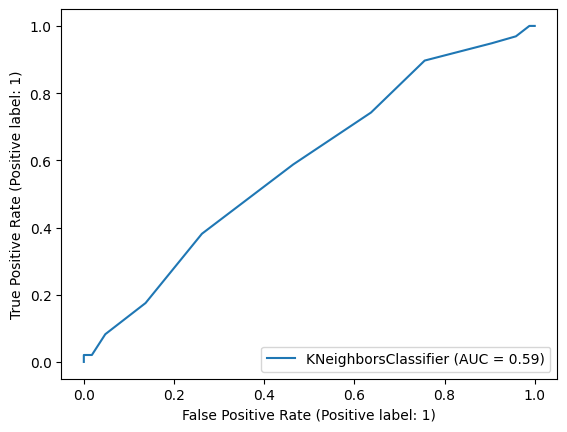

C:\ProgramData\Anaconda3\envs\data_lord\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.



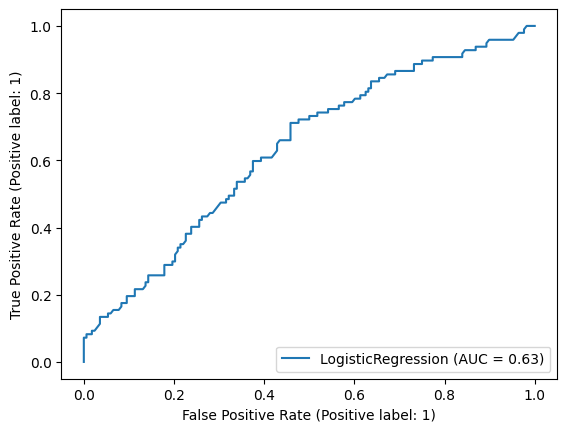

In [155]:
# ROC curve for kNN
metrics.plot_roc_curve(knn_model,X_test,y_test)
plt.show()

# ROC curve for Logistic Model
metrics.plot_roc_curve(lr_model,X_test,y_test)
plt.show()

### 6.4. Final Model Selection <a class="anchor" id="final-model"></a>
For the current dataset, we will select Logistic regression model because of following reasons:

> 1. kNN model has shown very poor performance. The accuracy of kNN model is not even exceeding Naive baseline of 65%, thus we will not select kNN model.
>
> 2. Logistic model performs much better than kNN model and the model's accuracy is better than the naive baseline of 64%
> 
> 3. The precision power of the logistic model is 100%, whereas the kNN model is 47%.
>
> 4. the Area under the Curve of of logistic regression model is higher than kNN classifier model. This indicates that logistic model will perform better than kNN on various probability thresholds.

*Note: We have selected the model based on Accuracy, Precision, Recall and Area under the curve

* [Go to Machine Learning](#ml-model)
* [Go to Top](#table-of-content)

### 6.5. Performance Evaluation <a class="anchor" id="performance-evaluation"></a>

Before analyzing the model at different probability threshold, following costs are associated with errors (False Positive and False Negative)

- Positive in our case indicates flight will be delayed


- **False Positive** 
    - Incorrectly predicting that the flight will be delayed even if the flight is on time.
    - **Cost of False Positive** - Customers will be falsely informed that their flight has been delayed by the airline team. As a result, the majority of customers will miss their flights, lowering their overall experience.    
    
- **False Negative** 
    - Incorrectly predicting that the flight is on time even if the flight is delayed.
    - **Cost of False Negative** - Even if the flight is delayed, the airline team will not send any flight delay notifications to customers in this scenario. The airline industry can manage a low false negative rate because they have a small number of customers who arrive early to the airport; however, a high false negative rate will increase dissatisfaction among a large number of customers if they have to stay at the airport for an extended period of time.
    
    
- The model is used by the airline's team to improve customer's experience, thus they want to **minimize the false positives** and wants to efficiently notify the customers of flight delay.

---


#### Performance Evaluation at different thresholds

1. **Probability Threshold = 0.2**: <br>
relative low threshold to predict positive outcomes.
    - A low threshold value results in a **89% false positive rate**, which means that the model will predict the flight being delayed 60% of the time even if the flight is not delayed.
    - The model's **accuracy is only 41%**. This level of accuracy is **significantly lower than our naive baseline**. This implies that the model will perform worse than manually predicting if the flight is delayed or not.
    - **False negative is 6.2%** i.e. even if the flight is delayed, the 6.2% times model will be unable to predict it.
    - Since our goal is to mininize the False postive, and 0.2 threshold results in **89% False positive rate and accuracy lower than naive baseline**, we **cannot use a relatively low threshold of 0.2**

---
<br><br>
1. **Probability Threshold = 0.8**: <br>
relatively high threshold to predict positive outcomes.<br>
    - A high threshold value results in a **92.8% false negative rate**, which means that the 92.8% times model will incorrectly predict that flight is on time even if the flight is delayed. Since customers wont be notfied of the delay in advance, they will have to wait at the airport for longer time. This will result in poor customer experience.
    - The model's **accuracy is 66%**. The accuracy is **better than the threshold of 0.2**, and is **better than our naive baseline**. This implies that the model will perform slightly better than manually predicting flight delay.
    - **False Positive rate is 0%**, which means that the model will accurately predict the flight delay without any errors. However **100% False negative rate will result in dissatisfaction among customers** due to no notification and extra waiting at the airport. This will indicate poor customer experience.
    - **Since False negative rate is too high**, we **cannot use a relatively high threshold of 0.8**
    
<br><br>
1. **Probability Threshold = 0.5**: <br>
medium threshold to predict positive outcomes.
    - A threshold value of 0.5 results in a **1.2% false positive rate**, such a low value indicates that the model will mostly acurately predict the flight delay without any errors.
    - **Precision is 80%** i.e. model's prediction of flight delay will be correct 80% of the time.
    - The model's **accuracy is also 65.7%**. The accuracy is way **better than the threshold of 0.2 and almost similar to accuracy achieved with 0.8 probability threshold**, and it is also **higher than our naive baseline of 64%**. This implies that the model will perform much better than manually predicting task completion.
    - **91.8% false negative rate** , which means that the 91.8% times model will incorrectly predict that flight is on time even if the flight is delayed. Since customers wont be notfied of the delay in advance, they will have to wait at the airport for longer time. This will result in poor customer experience.
    - Since **False positive rate is very low, precision is 80% and accuracy is higher than naive baseline**, and our agenda was to minimize the false positive, **threshold of 0.5 is better than 0.2 and 0.8 probability threshold level**    
    
<br><br>

* [Go to Machine Learning](#ml-model)
* [Go to Top](#table-of-content)


## 7. Conclusion <a class="anchor" id="conclusion"></a>

**Final Model and threshold**<br>
We will use Logistic regression with threshold probability of 51%

**Model Performance at 0.51 threshold**
- 0.51 threshold results in a model with highest precision of 100%, in other words, model's prediction of flight delay will always be correct.
- Model's accuracy will be around 66%, which means that, the 66% of time model will correctly predict is the flight is delayed or not.  
- Additionaly, the false positive rate is very low (0%). It indicates that airline team will be able to predict the flight delay 100% of the time. 

<br>

* [Go to Top](#table-of-content)


## 8. Deployment <a class="anchor" id="deployment"></a>

In [156]:
pickle_out = open('rr_assignment3_p2_files', mode='wb')
pickle.dump([lr_model,knn_model,scaler,lr_model_metrics,knn_model_metrics], pickle_out)
pickle_out.close()

In [157]:
# lr_model_metrics[lr_model_metrics['threshold']>=0.6]['Accuracy']

In [158]:
# pickle_in = open('rr_assignment3_p2_files', 'rb')
# p1_files = pickle.load(pickle_in)
# p1_files

In [159]:
%%writefile app2.py

import pickle
import streamlit as st
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

pickle_in = open('rr_assignment3_p1_files', 'rb')
p1_files = pickle.load(pickle_in)
p1_lr_classifier = p1_files[0]
p1_knn_classifier = p1_files[1]
p1_scaler = p1_files[2]
p1_lr_model_metrics=p1_files[3]
p1_knn_model_metrics=p1_files[4]

pickle_in = open('rr_assignment3_p2_files', 'rb')
p2_files = pickle.load(pickle_in)
p2_lr_classifier = p2_files[0]
p2_knn_classifier = p2_files[1]
p2_scaler = p2_files[2]
p2_lr_model_metrics=p2_files[3]
p2_knn_model_metrics=p2_files[4]

# @st.cache()

# st.title(" ASSIGNMENT 3 - PROBLEM SET 1")

st.write("""
## ASSIGNMENT 3 - kNN and Logistic classifier
Which one is the best
""")

dataset_name = st.sidebar.selectbox("Select Dataset",("System Administrator","Flight Delay","Loan Approval"))

classifier_name = st.sidebar.selectbox("Select Classifier",("Logistic Regression","kNN"))

def model_selection(dataset_name,classifier_name):
    if dataset_name == 'System Administrator':
        if classifier_name == 'Logistic Regression':
            model = p1_lr_classifier
        elif classifier_name == 'kNN':
            model = p1_knn_classifier
    elif dataset_name == 'Flight Delay':
        if classifier_name == 'Logistic Regression':
            model = p2_lr_classifier
        elif classifier_name == 'kNN':
            model = p2_knn_classifier
    
    return model

def model_params_default_value(dataset_name,classifier_name):
    default_params = dict()
    if dataset_name == 'System Administrator':
        if classifier_name == 'Logistic Regression':
            default_params['th']=0.46
        else:
            default_params['th']=0.4
            default_params['k']=9
    elif dataset_name == 'Flight Delay':
        if classifier_name == 'Logistic Regression':
            default_params['th']=0.51
        else:
            default_params['th']=0.4
            default_params['k']=19
    else:
        if classifier_name == 'Logistic Regression':
            default_params['th']=0.0
        else:
            default_params['th']=0.0
            default_params['k']=0
    
    return default_params
    

def model_params(dataset_name,classifier_name):
    params = dict()
    default_params = model_params_default_value(dataset_name,classifier_name)
    if classifier_name == 'Logistic Regression':
        th = st.sidebar.slider("Select Probability Threshold for the Model",0.0,1.0,value=default_params['th'],step=0.01)
        params['th']=th
    elif classifier_name == 'kNN':
        th = st.sidebar.slider("Select Probability Threshold for the Model",0.0,1.0,value=default_params['th'],step=0.1)
        params['th']=th
        k = st.sidebar.slider("Optimal value of k for the model",1,21,value=default_params['k'],step=2,disabled=True)
        params['k']=k
    
    return params

def plot_perfomance_metrics(model_metrics):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=model_metrics['threshold'], y=model_metrics['Precision'],
                        mode='lines',
                        name='Precision'))
    fig.add_trace(go.Scatter(x=model_metrics['threshold'], y=model_metrics['Recall'],
                        mode='lines',
                        name='Recall'))
    fig.add_trace(go.Scatter(x=model_metrics['threshold'], y=model_metrics['F1'],
                        mode='lines', name='F1'))
    fig.add_trace(go.Scatter(x=model_metrics['threshold'], y=model_metrics['Accuracy'],
                        mode='lines', name='Accuracy'))
    fig.update_layout(legend_title_text = "Performance Measures")
    fig.update_xaxes(title_text="Threshold")

#     fig.show()
    st.plotly_chart(fig, use_container_width=True)

def model_performance_metrics(dataset_name,classifier_name,model_parameters):
    if dataset_name == 'System Administrator':
        if classifier_name == 'Logistic Regression':
            model_metrics = p1_lr_model_metrics
        elif classifier_name == 'kNN':
            model_metrics = p1_knn_model_metrics
    elif dataset_name == 'Flight Delay':
        if classifier_name == 'Logistic Regression':
            model_metrics = p2_lr_model_metrics
        elif classifier_name == 'kNN':
            model_metrics = p2_knn_model_metrics
    
    st.sidebar.markdown("""---""")
#     st.sidebar.write('### Performance Metrics:')
    with st.sidebar.expander('Performance Metrics:'):
        st.write('Accuracy : ',
                         round(100*model_metrics[model_metrics['threshold']>=model_parameters['th']]['Accuracy'].values[0]),
                         '%'
                        ) 
                        # greater than because equal sign was not able to match the threshold value
        st.write('Precision : ',
                         round(100*model_metrics[model_metrics['threshold']>=model_parameters['th']]['Precision'].values[0]),
                         '%'
                        )
        st.write('Recall : ',
                         round(100*model_metrics[model_metrics['threshold']>=model_parameters['th']]['Recall'].values[0]),
                         '%'
                        )
        st.write('F1 Score : ',
                         round(100*model_metrics[model_metrics['threshold']>=model_parameters['th']]['F1'].values[0]),
                         '%'
                        )
        st.write('FPR : ',
                         round(100*model_metrics[model_metrics['threshold']>=model_parameters['th']]['FP_rate'].values[0]),
                         '%'
                        )
        st.write('FNR : ',
                         round(100*model_metrics[model_metrics['threshold']>=model_parameters['th']]['FN_rate'].values[0]),
                         '%'
                        )
    
    st.sidebar.markdown("""---""")
    
    return model_metrics

def get_data_system_administrator():
    
    years_of_experience = st.number_input("Number of years of experience",
                              min_value=0.0,
                              max_value=20.0,
                              value=5.0,
                              step=0.1,
                             )
    # normalize user input using the scaler used during training of model 
    years_of_experience = p1_scaler.transform([[years_of_experience]])
#     st.write(years_of_experience[0][0])

    training_level_4=0
    training_level_6=0
    training_level_8=0

    training_level = st.selectbox("Select Training Level",("Level 4","Level 6","Level 8"))
    if training_level == 'Level 4':
        training_level_4=1
    elif training_level == 'Level 6':
        training_level_6=1
    elif training_level == 'Level 8':
        training_level_8=1

    return [[years_of_experience[0][0],training_level_4,training_level_6,training_level_8]]

def get_data_flight_delay():
    # display selection of departure time and carrier in same row
    col1, col2 =st.columns(2)
    
    # select scheduled departure time
    scheduled_departure_time = col1.number_input("Scheduled Departure Time",
                              min_value=0.00,
                              max_value=23.99,
                              value=10.00,
                              step=0.01,
                             )
    # normalize user input using the scaler used during training of model 
    scheduled_departure_time = p2_scaler.transform([[scheduled_departure_time]])
    
    # select carrier
    carrier_delta=0
    carrier_us=0
    carrier_envoy=0
    carrier_continental=0
    carrier_discovery=0
    carrier_other=0
    
    carrier = col2.selectbox("Select Carrier",("Delta","US","Envoy","Continental","Discovery","Other"))
    if carrier == 'Delta':
        carrier_delta=1
    elif carrier == 'US':
        carrier_us=1
    elif carrier == 'Envoy':
        carrier_envoy=1
    elif carrier == 'Continental':
        carrier_continental=1
    elif carrier == 'Discovery':
        carrier_discovery=1
    elif carrier == 'Other':
        carrier_other=1
    
    # display selection of departure time and carrier in same row
    col1, col2 =st.columns(2)
    
    # select destination
    dest_jfk=0
    dest_ewr=0
    dest_lga=0
    
    destination = col1.selectbox("Select Destination Airport",("John F. Kennedy Airport",
                                                             "Newark Liberty International Airport",
                                                             "LaGuardia Airport"))
    if destination == 'John F. Kennedy Airport':
        dest_jfk=1
    elif destination == 'Newark Liberty International Airport':
        dest_ewr=1
    elif destination == 'LaGuardia Airport':
        dest_lga=1
    
    # select origin
    origin_dca=0
    origin_iad=0
    origin_bwi=0
    
    origin = col2.selectbox("Select Origin Airport",("Ronald Reagan Washington National Airport",
                                                   "Dulles International Airport",
                                                   "Baltimore/Washington International Airport"))
    if origin == 'Ronald Reagan Washington National Airport':
        origin_dca=1
    elif origin == 'Dulles International Airport':
        origin_iad=1
    elif origin == 'Baltimore/Washington International Airport':
        origin_bwi=1
    
    # display selection of weather and day name in same row
    col1, col2 =st.columns(2)
    
    # select weather
    bad_weather=0
    
    weather = col1.selectbox("Select Weather",("Cloudy/Rainy","Clear Sky"))
    if weather == 'Cloudy/Rainy':
        bad_weather=1
    
    # select day_name
    Monday=0
    Tuesday=0
    Wednesday=0
    Thursday=0
    Friday=0
    Saturday=0
    Sunday=0
    
    day_name = col2.selectbox("Select WeekDay Name",("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"))
    if day_name == 'Monday':
        Monday=1
    elif day_name == 'Tuesday':
        Tuesday=1
    elif day_name == 'Wednesday':
        Wednesday=1
    elif day_name == 'Thursday':
        Thursday=1
    elif day_name == 'Friday':
        Friday=1
    elif day_name == 'Saturday':
        Saturday=1
    elif day_name == 'Sunday':
        Sunday=1 
        
    return [[scheduled_departure_time[0][0],carrier_delta,carrier_us,carrier_envoy,carrier_continental,
             carrier_discovery,carrier_other,dest_jfk,dest_ewr,dest_lga,origin_dca,origin_iad,origin_bwi,
             bad_weather,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday]]

def get_data(dataset_name):
    if dataset_name == 'System Administrator':
        new_data = get_data_system_administrator()
    elif dataset_name == 'Flight Delay':
        new_data = get_data_flight_delay()
    
    return new_data

def message_1(dataset_name):
    if dataset_name == 'System Administrator':
        message = 'Task will be completed'
    elif dataset_name == 'Flight Delay':
        message = 'Flight will be delayed'
    
    return message

def message_0(dataset_name):
    if dataset_name == 'System Administrator':
        message = 'Task will not be completed'
    elif dataset_name == 'Flight Delay':
        message = 'Flight will be on time'
    
    return message
        
def prediction(classifier_name,dataset_name,new_data,model_parameters):
    model = model_selection(dataset_name,classifier_name)
    predicted_probability = model.predict_proba(new_data)[0][1]
    mess_1 = message_1(dataset_name)
    mess_0 = message_0(dataset_name)
    
    st.write('Predicted probability is ',round(predicted_probability*100,2),'%')
    st.write('Threshold probability is ',round(model_parameters['th']*100,2),'%')
    
    if predicted_probability < model_parameters['th']:
        pred = mess_0
        st.success(pred)
    else:
        pred = mess_1
        st.error(pred)

    return pred



model_parameters= model_params(dataset_name,classifier_name)
model_metrics=model_performance_metrics(dataset_name,classifier_name,model_parameters)

# page layout
new_data = get_data(dataset_name)
if st.button('Predict'):
    result = prediction(classifier_name,dataset_name,new_data,model_parameters)
#     st.success(result)

st.markdown("""---""")

st.write('Perfromance measures for different thresholds')
plot_perfomance_metrics(model_metrics)

# st.write(lr_model_metrics)

# # When 'Predict' is clicked, make the prediction and store it
# if st.button("Predict"):
#     result = prediction(classifier_name,dataset_name)
#     st.success(result)

Overwriting app2.py


In [160]:
!streamlit run app2.py

^C


In [161]:
# !streamlit hello

* [Go to Top](#table-of-content)

## !! End !!